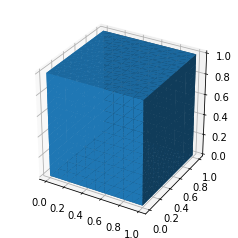

In [80]:
from __future__ import print_function
from fenics import *
import numpy as np
import dolfin as df
import os 
import matplotlib.pyplot as plt

# Create mesh and define function space

l = 1.0 
p0 = (0.0, 0.0, 0.0)
p1 = (l, l, 0.0)
nx = 20.0
ny = 20.0
nz = 1.0

mesh = BoxMesh(Point(0,0, 0), Point(1, 1, 1), 10, 10, 10, )

plot(mesh)


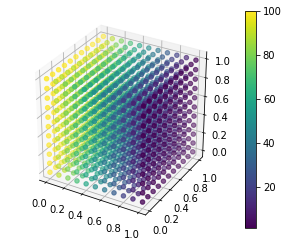

In [109]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class East(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 1.0)

class West(SubDomain):
    def inside(self, x , on_boundary):
       return near(x[1], 0.0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > 1.0 - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 


bcs = [DirichletBC(V, Constant(0), East()),
       DirichletBC(V, Constant(1), West())]




# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)



# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
graph=plot(u)
#plt.colorbar(cax=x[0],0. , mappable, **kwargs)[source]
plt.colorbar(graph);

In [110]:
a = kappa*dot(grad(u), grad(v))*dx + r*u*v*ds(R)
L = f*v*dx - g*v*ds(N) + r*s*v*ds(R)

integrals_N = []
for i in boundary_conditions:
    if 'Neumann' in boundary_conditions[i]:
        if boundary_conditions[i]['Neumann'] != 0:
            g = boundary_conditions[i]['Neumann']
            integrals_N.append(g*v*ds(i))

F = kappa*dot(grad(u), grad(v))*dx + \ sum(integrals_R) - f*v*dx + sum(integrals_N)

a, L = lhs(F), rhs(F)

import sympy as sym
h = 1
x, y = sym.symbols('x[0], x[1]')            # needed by UFL
u = 1 + x**2 + 2*y**2                       # exact solution
u_e = u                                     # exact solution
u_00 = u.subs(x, 0)                         # restrict to x = 0
u_01 = u.subs(x, 1)                         # restrict to x = 1
f = -sym.diff(u, x, 2) - sym.diff(u, y, 2)  # -Laplace(u)
f = sym.simplify(f)                         # simplify f
g = -sym.diff(u, y).subs(y, 1)              # compute g = -du/dn


# Collect variables
variables = [u_e, u_00, u_01, f, g, r, s]

# Turn into C/C++ code strings
variables = [sym.printing.ccode(var) for var in variables]

# Turn into FEniCS Expressions
variables = [Expression(var, degree=2) for var in variables]

# Extract variables
u_e, u_00, u_01, f, g, r, s = variables

# Define boundary conditions
boundary_conditions = {0: {'Dirichlet': u_00},   # x = 0
                       1: {'Dirichlet': u_01},   # x = 1
                       2: {'Neumann':   g}}      # y = 1


SyntaxError: unexpected character after line continuation character (<ipython-input-110-50151926d260>, line 11)